In [44]:
import os
import gc
import ast
import numpy as np 
import pandas as pd 

from google.colab import files
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm.notebook import tqdm

import plotly.express as px
import plotly.graph_objects as go
import plotly
plotly.offline.init_notebook_mode(connected = True)

import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import models

from sklearn.model_selection import train_test_split


In [13]:
# # Constants and hyperparameters
# MAIN_PATH = '../input/quickdraw-doodle-recognition'
# PREP_DATASET_PATH = '../input/doodle-recognition-prepaired-train-data' 
# TRAIN_SIMPLIFIED_PATH = '../input/quickdraw-doodle-recognition/train_simplified'


# Hardcoded constants, don't change them
NCATS = 340
BASE_SIZE = 256 
NCHANNELS = 3

#Fix seeds
SEED = 42
np.random.seed(seed=SEED)
tf.random.set_seed(seed=SEED)

#Hyperparameters
INPUT_SIZE = 64
ALPHA = 1. #Check MobileNetv2 documentation for explanations
EPOCHS = 100
BATCH_SIZE = 64

In [14]:
! nvidia-smi

Mon Jul 27 21:32:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download prepaired dataset from kaggle
30 000 images per class

In [4]:
# Add kaggle.json key
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gooogr","key":"3355d8a0ad1d1fdfb76ef01a7df4151c"}'}

In [5]:
! mkdir ~/.kaggle #inroot folder 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download gooogr/doodle-recognition-prepaired-train-data
! unzip /content/doodle-recognition-prepaired-train-data.zip

 98% 1.33G/1.35G [00:09<00:00, 143MB/s]
100% 1.35G/1.35G [00:09<00:00, 146MB/s]
Archive:  /content/doodle-recognition-prepaired-train-data.zip
  inflating: train_set_30000_340     


In [7]:
%%time
df = pd.read_csv('train_set_30000_340', compression='gzip')

CPU times: user 1min 2s, sys: 2.92 s, total: 1min 5s
Wall time: 1min 7s


### Utils

In [26]:
# Utils

def str2list(x):
    return(ast.literal_eval(x))

def draw_cv2(raw_strokes, size=64, lw=4, time_color=False):
    '''
    Took from https://www.kaggle.com/gaborfodor/greyscale-mobilenet-lb-0-892 #6
    '''
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255
            img = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) # 2d grey to 3d RGB matrix
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img
    
def plot_learnning_curves(history):
    loss = history.history['loss']
    categorical_accuracy = history.history['categorical_accuracy']
    val_loss = history.history['val_loss']
    val_categorical_accuracy = history.history['val_categorical_accuracy']
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=loss, mode='lines+markers', name='loss'))
    fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=val_loss, mode='lines+markers', name='val_loss'))
    fig.update_layout(autosize=False,
                      width=900,
                      height=300,
                      margin=dict(l=5, r=5, b=10, t=10, pad=4))
    fig.show()
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=categorical_accuracy, mode='lines+markers', name = 'accuracy'))
    fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=val_categorical_accuracy, mode='lines+markers', name = 'val_accuracy'))
    fig.update_layout(autosize=False,
                      width=900,
                      height=300,
                      margin=dict(l=5, r=5, b=10, t=10, pad=4))
    fig.show()

### Data downloading

In [24]:
# Encode categories to numbers
categories_list = sorted(df.word.unique(), key = str.lower)
categories_dict = dict(zip(categories_list, range(len(categories_list))))
df['word_code'] = df['word'].map(categories_dict)

In [10]:
%%time
train_df, valid_df = train_test_split(df, train_size=0.9, stratify=df['word'])

CPU times: user 25.1 s, sys: 535 ms, total: 25.7 s
Wall time: 25.7 s


In [11]:
train_df.head()

,drawing,word,key_id,word_code
5056061,"[[[158, 150, 131, 86, 48, 21, 11, 3, 5, 13, 19...",hurricane,5451329902215168,154
8195044,"[[[0, 4, 0, 2, 6, 12, 23, 38, 55, 74, 86, 89, ...",tooth,4699206709149696,311
162000,"[[[121, 120, 82, 29, 6, 0, 0, 6, 14, 44, 99, 1...",shoe,4829660816867328,255
8326125,"[[[232, 217, 201, 191, 190, 196, 206, 220, 239...",cat,4993335812947968,63
10178516,"[[[150, 150, 155, 162, 172, 180, 178, 168, 156...",scorpion,5542684905177088,249


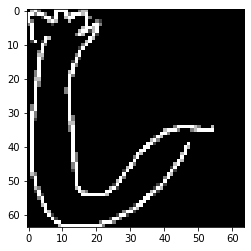

CPU times: user 577 ms, sys: 3.91 ms, total: 581 ms
Wall time: 589 ms


In [27]:
%%time
# Check image convertation step
img_coords_sample = str2list(df[df['word'] == 'arm']['drawing'].values[0])
img = draw_cv2(img_coords_sample, size = INPUT_SIZE)
plt.imshow(img)
plt.show()

### Keras generator

In [32]:
class DataGenerator(Sequence):
    def __init__(self, list_drawings, labels = None, 
                 batch_size=BATCH_SIZE, dim=(INPUT_SIZE, INPUT_SIZE, NCHANNELS),
                 n_channels=NCHANNELS, n_classes=NCATS, 
                 shuffle=True, is_test=False):
        """
        Initialization
        :param list_drawings: list of all drawings coordinates that use in the generator
        :param labels: list of image labels (file names), our targets
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.list_drawings = list_drawings
        self.indexes = np.arange(len(self.list_drawings))
        self.is_test = is_test
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

        if not is_test:    
            self.n_classes = n_classes    
            self.labels = labels
            
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True and not self.is_test:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        l = int(np.floor(len(self.list_drawings) / self.batch_size))+1
        return l
    
    def __getitem__(self, index):
        """
        Generate data batch
        """
        # Generate batch indexes
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Get image IDs
        temp_draw_list = [self.list_drawings[i] for i in indexes]
        temp_label_list = [self.labels[i] for i in indexes]
        if not self.is_test:
            X, y = self.__generate_train_data(temp_draw_list, temp_label_list)
            return X, y
        else:
            X = self.__generate_test_data(temp_draw_list)
            return X
    
    def __generate_train_data(self, temp_draw_list, temp_label_list):
        # Initialization
        X = np.empty((len(temp_draw_list), *self.dim))
        y = np.empty((len(temp_draw_list)), dtype=np.int16)
        # Fill data
        for i, draw in enumerate(temp_draw_list):
            img = draw_cv2(str2list(draw), size = self.dim[0])            
            X[i, ] = img #np.expand_dims(img, axis = -1)
            y[i, ] = temp_label_list[i]
        return X, to_categorical(y, num_classes=self.n_classes)
    
    def __generate_test_data(self, temp_draw_list):
        # Initialization
        X = np.empty((len(temp_draw_list), *self.dim))
        # Fill data
        for i, draw in enumerate(temp_draw_list):
            img = draw_cv2(str2list(draw), size = self.dim[0])            
            X[i, ] = img #np.expand_dims(img, axis = -1)
        return X
        
    
        

In [33]:
train_gen = DataGenerator(list_drawings=train_df.drawing.values, 
                          labels=train_df.word_code.values, 
                          batch_size=BATCH_SIZE)
valid_gen = DataGenerator(list_drawings=valid_df.drawing.values, 
                          labels=valid_df.word_code.values, 
                          batch_size=BATCH_SIZE)
# test_gen = DataGenerator(list_drawings=test_df.drawing.values, 
#                           is_test=True, 
#                           batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X shape: (64, 64, 64, 3), y shape: (64, 340)


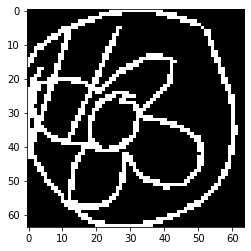

CPU times: user 139 ms, sys: 3.08 ms, total: 142 ms
Wall time: 146 ms


In [35]:
%%time
# Check generator
X, y = train_gen.__getitem__(index=1)
print('X shape: {}, y shape: {}'.format(X.shape, y.shape))
plt.imshow(X[0, :, :, :])
plt.show()

### Keras MobileNetv2<br>
MobileNetv2 docs: https://keras.io/api/applications/mobilenet/

In [36]:
# model_callbacks = [EarlyStopping(monitor='val_loss', 
#                                  patience=10, 
#                                  restore_best_weights = True),
                   
model_callbacks = [ModelCheckpoint(filepath='MobileNetV2.epoch={epoch:02d}-val_loss={val_loss:.2f}.h5',
                                   save_weights_only=False,
                                   monitor='val_categorical_accuracy', 
                                   save_best_only=False),
                  
                  CSVLogger('log.csv', append=True, separator=';'),
                  
                  ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.75, patience=5, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1)]

In [ ]:
# ADD Data augmentation

# ADD Tranfer learning and freeze first layers

In [52]:
def create_model():
    model = models.Sequential(MobileNetV2(input_shape=(INPUT_SIZE, INPUT_SIZE, NCHANNELS), 
                              alpha=ALPHA, 
                              include_top=False,
                              weights='imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NCATS, activation = 'softmax'))
    return model

In [53]:
model = create_model()
model.compile(optimizer=Adam(lr=0.01), 
              loss='categorical_crossentropy',
              metrics=['categorical_crossentropy', 'categorical_accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 340)               348500    
Total params: 3,918,228
Trainable params: 3,884,116
Non-trainable params: 34,112
_________________________________________________________________
None


In [ ]:
history = model.fit_generator(generator=train_gen, 
                           validation_data=valid_gen, 
                           epochs=EPOCHS, 
                           verbose=1,
                           steps_per_epoch=10000, #len(train_df) // BATCH_SIZE
                           validation_steps=500,
                           callbacks=model_callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
10000/10000 [==============================] - 386s 39ms/step - loss: 5.2034 - categorical_crossentropy: 5.2034 - categorical_accuracy: 0.0212 - val_loss: 8.9914 - val_categorical_crossentropy: 8.9914 - val_categorical_accuracy: 0.0105 - lr: 0.0100
Epoch 2/100
10000/10000 [==============================] - 382s 38ms/step - loss: 4.8440 - categorical_crossentropy: 4.8440 - categorical_accuracy: 0.0440 - val_loss: 5.6591 - val_categorical_crossentropy: 5.6591 - val_categorical_accuracy: 0.0169 - lr: 0.0100
Epoch 3/100
10000/10000 [==============================] - 379s 38ms/step - loss: 4.6475 - categorical_crossentropy: 4.6475 - categorical_accuracy: 0.0611 - val_loss: 5.8049 - val_categorical_crossentropy: 5.8049 - val_categorical_accuracy: 0.0138 - lr: 0.0100
Epoch 4/100
10000/10000 [==============================] - 379s 38ms/step - loss: 4.4023 - categorical_crossentropy: 4.4023 - categorical_acc

In [ ]:
plot_learnning_curves(history)